<a href="https://colab.research.google.com/github/axel-sirota/practical-nlp/blob/main/1-simiarity/Practical_NLP_5_LTR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Fri Oct 14 14:52:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install 'gensim==4.2.0'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 1.5 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [20]:
import multiprocessing
import tensorflow as tf
import sys
import keras.backend as K
from keras.models import Sequential
from tensorflow.keras import layers, activations, losses, Model, Input
from keras.layers import Dense, Embedding, Lambda
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from textblob import TextBlob, Word
from keras_preprocessing.sequence import pad_sequences
from keras.initializers import Constant
from tensorflow.nn import leaky_relu
from tensorflow.keras.utils import plot_model, Progbar
from gensim.models import Doc2Vec
import gensim
import numpy as np
import random
import os
import pandas as pd
import gensim
import warnings
import nltk
from sklearn.model_selection import train_test_split
from itertools import combinations
import matplotlib.pyplot as plt


TRACE = False
embedding_dim = 100
epochs=50
batch_size = 50
sample_queries = 20
sample_results_dataset = 100



In [4]:
def set_seeds_and_trace():
  os.environ['PYTHONHASHSEED'] = '0'
  np.random.seed(42)
  tf.random.set_seed(42)
  random.seed(42)
  if TRACE:
    tf.debugging.set_log_device_placement(True)

def set_session_with_gpus_and_cores():
  cores = multiprocessing.cpu_count()
  gpus = len(tf.config.list_physical_devices('GPU'))
  config = tf.compat.v1.ConfigProto( device_count = {'GPU': gpus  , 'CPU': cores} , intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
  sess = tf.compat.v1.Session(config=config) 
  K.set_session(sess)

set_seeds_and_trace()
set_session_with_gpus_and_cores()
warnings.filterwarnings('ignore')

The idea behind RankNet is to model the **joint probability** that `document i` comes before `document j` as the following:

$P_{ij} = 1$ if $s_i > s_j$
$P_{ij} = 0.5$ if $s_i = s_j$
$P_{ij} = 0$ if $s_i < s_j$

So for *every pair of inputs* we will calculate both outputs, substract them, pass a logistic function to model the probability:

<img src="./ranknet.png">

In [5]:
%%writefile get_data.sh

if [ ! -f yelp.csv ]; then
  wget -O yelp.csv https://www.dropbox.com/s/xds4lua69b7okw8/yelp.csv?dl=0
fi
if [ ! -f doc2vec_yelp_model ]; then
  wget -O doc2vec_yelp_model https://www.dropbox.com/s/bibu9bashb0cd68/doc2vec_yelp_model?dl=0
fi

Writing get_data.sh


In [6]:
!bash get_data.sh

--2022-10-14 14:53:08--  https://www.dropbox.com/s/xds4lua69b7okw8/yelp.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/xds4lua69b7okw8/yelp.csv [following]
--2022-10-14 14:53:10--  https://www.dropbox.com/s/raw/xds4lua69b7okw8/yelp.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9466b1dac10912a34905555252.dl.dropboxusercontent.com/cd/0/inline/BuyDpwow73MjDtN-JBOdxmCy5ea5JB9P-foL-To_Voqzeu8OMqWMCEPDRiayxmHKNmn02LgUpuU56RkTVejQacZk6U5nggXwgtOvXShpow-iS_sJHgfMB_dcQVjL5bnWlMoojUbxUV6A6pT-eYEPpX9dwCJVq-xnBCI_lPXB6LSI9w/file# [following]
--2022-10-14 14:53:10--  https://uc9466b1dac10912a34905555252.dl.dropboxusercontent.com/cd/0/inline/BuyDpwow73MjDtN-JBOdxmCy5ea5JB9P-foL-To_Voqzeu8OMqWMCEPDRiayxmHKNmn02LgUpuU56RkTVejQacZ

In [7]:
model = Doc2Vec.load("./doc2vec_yelp_model")

In [8]:
path = './yelp.csv'
yelp = pd.read_csv(path)
train_set_reviews = yelp.sample(n=sample_results_dataset).reset_index(drop=True)
queries = yelp.text.sample(n=sample_queries).reset_index(drop=True)

In [9]:
queries

0     I really try to like Old Town Scottsdale - and...
1     (aka. SKETCHY TEMPE with BONNIE G, Part One of...
2     Thought Saturday night would be busy at 6:00 P...
3     I was actually really impressed, even though I...
4     Pros:\n1.  Excellent service.  Hell, it's damn...
5     Treated with complete disrespect. Worst servic...
6     I met up with a girlfriend at borders. This Bo...
7     First time here and it was really good. I orde...
8     I'm on a low carb diet right now, so I had to ...
9     I got my nails done there last Thursday for th...
10    I was referred to Jones Family Dentistry for a...
11    Just went to this theater last night, and it w...
12    The Harkins Camelview 5 gives Arizonans the un...
13    Great new addition to the Old Town neighborhoo...
14    What can I say that hasn't already been said a...
15    This place is essentially a copy of the old Fa...
16    I have been coming here since discovering them...
17    Delicious barbecue, we had 4 meats platter

In [10]:
results = np.zeros((len(queries), len(train_set_reviews), 100))
scores = np.zeros((len(queries), len(train_set_reviews)))
for q_ix, query in enumerate(queries):
  for r_ix, review in enumerate(train_set_reviews):
    try:
        similarity = model.similarity_unseen_docs(doc_words1=list(gensim.utils.simple_preprocess(query)), doc_words2= list(gensim.utils.simple_preprocess(review)))
    except KeyError:
        similarity = 0
    feature = model.infer_vector(list(gensim.utils.simple_preprocess(review)))
    results[q_ix][r_ix] = feature
    scores[q_ix][r_ix] = similarity


In [11]:
# put data into pairs
xi = []
xj = []
pij = []
pair_id = []
pair_query_id = []
for q_ix, query in enumerate(queries):
    for pair_idx in combinations(enumerate(results[q_ix]), 2):
        pair_query_id.append(query)
        pair_id.append(pair_idx)
        ix_i, document_i = pair_idx[0]
        ix_j, document_j = pair_idx[1]
        xi.append(document_i)
        xj.append(document_j)

        if scores[q_ix][ix_i] == scores[q_ix][ix_j]:
            _pij = 0.5
        elif scores[q_ix][ix_i] > scores[q_ix][ix_j]:
            _pij = 1
        else:
            _pij = 0
        pij.append(_pij)

xi = np.array(xi)
xj = np.array(xj)
pij = np.array(pij)
pair_query_id = np.array(pair_query_id)
del results
del scores


In [12]:
xi_train, xi_test, xj_train, xj_test, pij_train, pij_test, pair_id_train, pair_id_test = train_test_split(
    xi, xj, pij, pair_id, test_size=0.2, stratify=pair_query_id)

In [13]:
xi_train = tf.constant(xi_train)
xi_test = tf.constant(xi_test)
xj_train = tf.constant(xj_train)
xj_test = tf.constant(xj_test)
pij_train = tf.constant(pij_train)
pij_test = tf.constant(pij_test)
pair_id_train = pair_id_train
pair_id_test = pair_id_test

In [14]:
# model architecture
class RankNet(Model):
    def __init__(self):
        super().__init__()
        self.dense = [layers.Dense(16, activation=leaky_relu), layers.Dense(8, activation=leaky_relu)]
        self.o = layers.Dense(1, activation='linear')
        self.oi_minus_oj = layers.Subtract()

    def call(self, inputs):
        xi, xj = inputs
        densei = self.dense[0](xi)
        densej = self.dense[0](xj)
        for dense in self.dense[1:]:
            densei = dense(densei)
            densej = dense(densej)
        oi = self.o(densei)
        oj= self.o(densej)
        oij = self.oi_minus_oj([oi, oj])
        output = layers.Activation('sigmoid')(oij)
        return output

    def build_graph(self):
        x = [Input(shape=(10)), Input(shape=(10))]
        return Model(inputs=x, outputs=self.call(x))

In [21]:
# train model using compile and fit
ranknet = RankNet()
ranknet.compile(optimizer='adam', loss='binary_crossentropy')
history = ranknet.fit([xi_train, xj_train], pij_train, epochs=epochs, batch_size=batch_size, validation_data=([xi_test, xj_test], pij_test))

Epoch 1/50
1584/1584 [==============================] - 5s 3ms/step - loss: 0.6233 - val_loss: 0.6161
Epoch 2/50
1584/1584 [==============================] - 5s 3ms/step - loss: 0.6152 - val_loss: 0.6130
Epoch 3/50
1584/1584 [==============================] - 5s 3ms/step - loss: 0.6116 - val_loss: 0.6095
Epoch 4/50
1584/1584 [==============================] - 5s 3ms/step - loss: 0.6080 - val_loss: 0.6051
Epoch 5/50
1584/1584 [==============================] - 5s 3ms/step - loss: 0.6043 - val_loss: 0.6034
Epoch 6/50
1584/1584 [==============================] - 5s 3ms/step - loss: 0.6031 - val_loss: 0.6029
Epoch 7/50
1584/1584 [==============================] - 4s 3ms/step - loss: 0.6025 - val_loss: 0.6023
Epoch 8/50
1584/1584 [==============================] - 6s 4ms/step - loss: 0.6021 - val_loss: 0.6020
Epoch 9/50
1584/1584 [==============================] - 5s 3ms/step - loss: 0.6019 - val_loss: 0.6020
Epoch 10/50
1584/1584 [==============================] - 5s 3ms/step - loss: 0.601

In [28]:
ranknet.summary()

Model: "rank_net_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            multiple                  1616      
                                                                 
 dense_13 (Dense)            multiple                  136       
                                                                 
 dense_14 (Dense)            multiple                  9         
                                                                 
 subtract_4 (Subtract)       multiple                  0         
                                                                 
Total params: 1,761
Trainable params: 1,761
Non-trainable params: 0
_________________________________________________________________


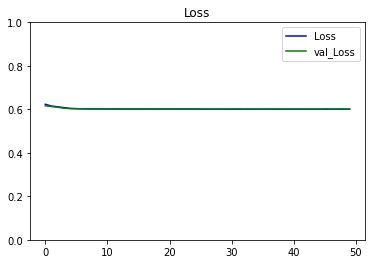

In [22]:
# function for plotting loss
def plot_metrics(train_metric, val_metric=None, metric_name=None, title=None, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(train_metric,color='blue',label=metric_name)
    if val_metric is not None: plt.plot(val_metric,color='green',label='val_' + metric_name)
    plt.legend(loc="upper right")

# plot loss history
plot_metrics(history.history['loss'], history.history['val_loss'], "Loss", "Loss", ylim=1.0)

In [33]:
new_doci = tf.constant([model.infer_vector(list(gensim.utils.simple_preprocess('This was the best french place in the world')))])
new_docj = tf.constant([model.infer_vector(list(gensim.utils.simple_preprocess('Wouldnt come back ever again')))])
inputs = tf.constant(np.array([new_doci, new_docj]))


In [34]:
inputs[0].shape

TensorShape([1, 100])

In [35]:
inputs[0]

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[-0.01484802, -0.01572138, -0.02401376,  0.00360791,  0.00858026,
        -0.03434326, -0.00303746,  0.06181582, -0.04121519,  0.0013705 ,
         0.01736436, -0.04558966, -0.02606856,  0.05313838,  0.02748182,
        -0.01010834, -0.02102506, -0.00101264, -0.01293747, -0.05078515,
         0.02430892,  0.0475943 ,  0.03893576,  0.00232368, -0.02713238,
         0.00366601, -0.04957069, -0.02590737, -0.04251442,  0.00635415,
         0.04378794, -0.02500792,  0.00234092, -0.04221196,  0.00285723,
         0.02950317, -0.00236419,  0.02041181, -0.00893302, -0.04340103,
        -0.01211206, -0.03778659, -0.01399105, -0.00432926,  0.01575397,
         0.02155238, -0.03246578,  0.00781459,  0.00284644,  0.02879379,
         0.02593884, -0.0617569 , -0.01840962, -0.03232995, -0.02742082,
         0.0070127 , -0.00037809, -0.03478675, -0.0211691 ,  0.00332741,
         0.00099683,  0.00594685,  0.02467218,  0.0001332 , -0.03985986,
 

In [36]:
ranknet(inputs)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>